## Pycrash - An open source tool for accident reconstruction
#### Demonstration of basic functionality: Accident Reconstruction formulae and methods

### Reconstruction Equations
- The `ar` module contains various equations that can be imported within your notebook or python script
- Pycrash nomenclature always uses vehicle 1 as striking, vehicle 2 as struck

#### Jupyter Notebook notes
- `ctrl+Enter` will run current cell
- `ctrl+Shift` will run current cell and move to next

In [1]:
# if running without installing from pip - insert path to pycrash here
import sys
sys.path.insert(0, '/Users/joe/Documents/pycrash')

In [2]:
# jupyter notebook option - allows for modules to be imported multiple times
%load_ext autoreload
%autoreload 2

#### Python packages used for analysis
- `pandas` - data analysis and manipulation tool
- `numpy` - The fundamental package for scientific computing with Python
- `sklearn` - higher level mathematical functionality

In [3]:
import pandas as pd
pd.options.display.max_columns = None  # show all dataframe columns
import numpy as np
from sklearn.linear_model import LinearRegression

### Import reconstruction equations

In [4]:
import pycrash.functions.ar as ar
import pycrash.functions.arPlots as arplot

Current values for defined constants:
maximum available friction (mu_max) = 0.76
time step for vehicle motion (dt) = 0.01 s
No Environment File Provided
No Environment File Provided


### Solve for delta-V

In [14]:
w1 = 3000     # <- vehicle 1 weight [lbs] (striking)
w2 = 5000     # <- vehicle 2 weight [lbs] (struck)
v1 = 10       # <- vehicle 1 initial speed [mph]
v2 = 0        # <- vehicle 2 initial speed [mph]

restitution = ar.cipriani_rest(v1-v2)    # <- solve for restitution using Cipriani et al. (2002) fit
ar.StrikingDV(w1, w2, v1, v2, restitution)

# print statement:
print(f'Striking vehicle change in speed: {StrikingDV(w1, w2, v1, v2, rest):0.1f} mph with restitution of: {restitution:0.2f}')

Striking vehicle change in speed: 6.9 mph with restitution of: 0.29


### Introduction to Pycrash Vehicle
- vehicle is a python class object that stores various information related to a vehicle
- this is a simple example requiring only vehicle weight and a name

In [15]:
# import Vehicle module
from pycrash.vehicle import Vehicle

In [16]:
# create vehicle
veh1 = Vehicle('Malibu')
veh1.year = 2015
veh1.make = 'Chevrolet'
veh1.model = 'Malibu'
veh1.weight = 3639

# show what is stored inside "veh1"
veh1.show()

name -> Malibu
type -> vehicle
year -> 2015
make -> Chevrolet
model -> Malibu
weight -> 3639


In [17]:
# retrieve value stored in vehicle class:
veh1.weight
print(f'The weight of {veh1.name} is: {veh1.weight} lbs')

The weight of Malibu is: 3639 lbs


#### A and B values from crash plot

In [18]:
# import crash_plot function
from pycrash.functions.vehicle_stiffness import crash_plot

In [19]:
# %% Create crash plot for A / B stiffness values
# initialize crash plot data
abscissa = np.array([])
ordinate = np.array([])

# create inputs for crash plot function
# %% create test with zero crush at 3 mph - only returns a single value for intercept at 0 crush
crush_length = 1415 * 0.0393701  # crush width [inches]

# 6 point crush profile
c_list = [0] * 6                # no crush
test_speed = 3                  # no crush speed [mph]
restitution = 0

test_data = {'test_crush':c_list,
             'test_speed':test_speed,
             'damage_length':crush_length,
             'epsilon':restitution}

x_no_damage, y_no_damage = crash_plot(test_data, veh1)
abscissa = np.append(abscissa, x_no_damage)  # append values to the array
ordinate = np.append(ordinate, y_no_damage)  # append values to the array

# crush measurements [inches], say average crush depth
c1 = 10.1
c2 = 10.1
c3 = 10.1
c4 = 10.1
c5 = 10.1
c6 = 10.1

crush_length = 1415 * 0.0393701  # crush width [inches]
# 6 point crush profile
c_list = [c1, c2, c3, c4, c5, c6]  # list of crush measurements

test_speed = 56.51 * 0.621371 # [mph]
restitution = 0.013           # <- from test data

# input data is put into a python dictionary for input
test_data = {'test_crush':c_list,
             'test_speed':test_speed,
             'damage_length':crush_length,
             'epsilon':restitution}

# crash_plot function returns the x,y values associated with the crash plot
ave_x, ave_y = crash_plot(test_data, veh1)
abscissa = np.append(abscissa, ave_x)  # append values to the array
ordinate = np.append(ordinate, ave_y)  # append values to the array

# add another data point to crash plot -
c1 = 13
c2 = 13
c3 = 13
c4 = 13
c5 = 13
c6 = 13

crush_length = 1415 * 0.0393701  # crush width [inches]

# 6 point crush profile
c_list = [c1, c2, c3, c4, c5, c6]

test_speed = 60 * 0.621371 # [mph]
restitution = 0.008  # <- from test data

test_data = {'test_crush':c_list,
             'test_speed':test_speed,
             'damage_length':crush_length,
             'epsilon':restitution
}

x_new, y_new = crash_plot(test_data, veh1)

abscissa = np.append(abscissa, x_new)  # append values to the array
ordinate = np.append(ordinate, y_new)  # append values to the array

average crush = 10.100000000000001, form factor = 0.9999999999999994, crush energy = 149844.2834620432
average crush = 13.0, form factor = 1.0, crush energy = 168942.0157583104


Crash plot data is complete - perform linear regression to get A / B values

In [20]:
# linear regression of crash plot data
model = LinearRegression().fit(abscissa.reshape((-1, 1)), ordinate)

# calculate A and B values:
A = (model.coef_ * model.intercept_).item()
B = (model.coef_** 2).item()

# assign A + B values to veh1
veh1.A = A
veh1.B = B

# data for crash plot
crash_plot_x = [*range(0, int(round(max(abscissa))) + 2, 1)]
crash_plot_y = [x * model.coef_.item() + model.intercept_ for x in crash_plot_x]

### Create a basic plot with Plotly -
Helpful to know the basic syntax for plots so formats in Pycrash plots can be changed

In [5]:
# import plotly
import plotly.graph_objects as go
# tell plotly to use browser for plotting
# if you are using jupyter notebook, then "notebook" will work for an option.
# otherwise, Pycharm and Jupyter Lab get along better with "browser"
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"  # <- determines how plots are displayed using Plotly
#pio.renderers.default = "browser"  # <- determines how plots are displayed using Plotly

In [22]:
# %% Create crash plot for A / B stiffness values
fig = go.Figure()
# velocity data
fig.add_trace(go.Scatter(x = abscissa, y = ordinate,
                        mode = 'markers',
                        name = '2015 Malibu',
                        marker = dict(color = 'rgb(102, 255, 51)', size = 8)))
fig.add_trace(go.Scatter(x = crash_plot_x, y = crash_plot_y,
                        mode = 'lines',
                        name = 'regression',
                        line = dict(color = 'rgb(67,67,67)', width = 2)))
fig.add_annotation(x = 2,
                    y = 200,
                    showarrow = False,
                    text = f"A = {A:.0f} lb/in<br>B = {B:.0f} lb/in/in")

fig.update_layout(
    legend=dict(
    yanchor="bottom",
    y=0.1,
    xanchor="left",
    x=0.7),
    autosize = False,
    width = 2000,
    height = 1100,
    title = 'Crash Plot',
    #template = 'plotly_white',  # turn off / on background color / grid
    xaxis = dict(showgrid = True, title = '(form factor) * average crush (in)'),
    yaxis = dict(showgrid = True, title = 'Energy Crush Factor'),
    font = dict(family = 'Arial', size = 16, color = 'black'))

#### Process NHTSA Load Cell Barrier Test
- process files downloaded from NTHSA website when choosing the "ascii" option
- produces a list of files, including the .EV5 file which contains channel information
- Pycrash module `process_nhtsa_loadcelldata` will load and process data to calculate Force-displacement response
- nothing is returned, a dataframe pickle file will be saved in the same directory containing the ascii data

In [6]:
# load modules
import os # operating system interface - used to change directories and create paths
import pycrash.functions.process_nhtsa_loadcelldata_ascii_ver1 as load_cell

In [7]:
# this test was missing data for two load cells, so F_1 was set to F_2 and C_4 was taken as the average of C_3 and C_5
# the function will ask for inputs to handle missing data
# the respective entries are F_1 and C_3, C_5

test_num = 10146
path = os.path.join(os.getcwd(), 'data', 'input', f'v{test_num}ascii')  # create path input
row_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']     # list of rows to be processed
num_columns = 17                                                       # number of load cell columns
impact_velocity = 57.09  # test impact speed [kph]

In [8]:
# two dataframes are produced, one containing the force across all columns summed
# the other contains the processed force data for each load cell
load_cell.process_loadcell_asii(test_num, path, row_list, num_columns, impact_velocity, english=True)

Instrumentation data found at line: 20
Instrumentation data found at line: 655
Channel: LEFT REAR SEAT CROSSMEMBER X #93
Channel: RIGHT REAR SEAT CROSSMEMBER X #94
Channel: LEFT REAR SEAT CROSSMEMBER XR #99
Channel: RIGHT REAR SEAT CROSSMEMBER XR #100
Channel: BARRIER K-01 Fx #107 at row: K, col: 1
Channel: BARRIER K-02 Fx #110 at row: K, col: 2
Channel: BARRIER K-03 Fx #113 at row: K, col: 3
Channel: BARRIER K-04 Fx #116 at row: K, col: 4
Channel: BARRIER K-05 Fx #119 at row: K, col: 5
Channel: BARRIER K-06 Fx #122 at row: K, col: 6
Channel: BARRIER K-07 Fx #125 at row: K, col: 7
Channel: BARRIER K-08 Fx #128 at row: K, col: 8
Channel: BARRIER K-09 Fx #131 at row: K, col: 9
Channel: BARRIER K-10 Fx #134 at row: K, col: 10
Channel: BARRIER K-11 Fx #137 at row: K, col: 11
Channel: BARRIER K-12 Fx #140 at row: K, col: 12
Channel: BARRIER K-13 Fx #143 at row: K, col: 13
Channel: BARRIER K-14 Fx #146 at row: K, col: 14
Channel: BARRIER K-15 Fx #149 at row: K, col: 15
Channel: BARRIER K-16 

Enter a list of column names to average to replace missing data: (example: C_3, C_5) F_2


Assigning missing column data to column F_2
Column C_4 = 0


Enter a list of column names to average to replace missing data: (example: C_3, C_5) C_3, C_5


LEFT REAR SEAT CROSSMEMBER X
RIGHT REAR SEAT CROSSMEMBER X
LEFT REAR SEAT CROSSMEMBER XR
RIGHT REAR SEAT CROSSMEMBER XR
Processing Complete - Files Saved to Path Provided


Import dataframe created from above

In [9]:
# individual forces:
force_dx = pd.read_pickle(os.path.join(path, f'ProcessedNHTSATestData_{test_num}.pkl'))
# first five rows:
force_dx.head()

,time,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,J_1,J_2,J_3,J_4,J_5,J_6,J_7,J_8,J_9,J_10,J_11,J_12,J_13,J_14,J_15,J_16,I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,I_10,I_11,I_12,I_13,I_14,I_15,I_16,H_1,H_2,H_3,H_4,H_5,H_6,H_7,H_8,H_9,H_10,H_11,H_12,H_13,H_14,H_15,H_16,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12,E_13,E_14,E_15,E_16,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10,D_11,D_12,D_13,D_14,D_15,D_16,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,C_11,C_12,C_13,C_14,C_15,C_16,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,B_9,B_10,B_11,B_12,B_13,B_14,B_15,B_16,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,A_11,A_12,A_13,A_14,A_15,A_16,A_Sum,B_Sum,C_Sum,D_Sum,E_Sum,F_Sum,G_Sum,H_Sum,I_Sum,J_Sum,K_Sum,LEFT REAR SEAT CROSSMEMBER X,LEFT REAR SEAT CROSSMEMBER X Velocity,LEFT REAR SEAT CROSSMEMBER X Disp,RIGHT REAR SEAT CROSSMEMBER X,RIGHT REAR SEAT CROSSMEMBER X Velocity,RIGHT REAR SEAT CROSSMEMBER X Disp,LEFT REAR SEAT CROSSMEMBER XR,LEFT REAR SEAT CROSSMEMBER XR Velocity,LEFT REAR SEAT CROSSMEMBER XR Disp,RIGHT REAR SEAT CROSSMEMBER XR,RIGHT REAR SEAT CROSSMEMBER XR Velocity,RIGHT REAR SEAT CROSSMEMBER XR Disp
0,0.0000,-12.629634,-18.957811,-30.065792,-6.881361,3.155432,28.226137,-6.331378,-9.695434,23.204202,7.250650,-35.363004,1.906778,8.669346,11.714389,-20.732525,9.507207,-1.589412,19.106409,-1.285641,14.049789,25.883780,-47.841888,21.232619,-87.014097,-70.385829,10.823767,-114.482360,-29.636798,-8.234607,-2.681569,-22.978463,-25.423241,16.501013,24.911782,2.209875,-18.944203,-9.108275,-4.945775,7.805421,-16.904740,-17.801445,12.359364,5.749130,-11.135311,3.587527,10.275850,-3.248734,12.010851,20.497647,-12.528579,13.551722,-5.597110,-1.383752,-3.737611,-4.786053,11.127624,78.088309,-12.436973,2.594008,12.015985,-22.368730,-10.827321,67.619574,21.199021,1.039592,-13.988943,-5.203030,-1.983665,78.908276,9.009731,-25.146877,-53.466379,-62.433114,-20.624432,32.636325,20.945328,11.118142,11.125358,38.877160,24.238550,6.180013,6.180013,6.478985,44.597248,-7.381531,-0.510813,-7.203252,20.826391,14.062037,-26.849217,5.002973,0.333779,-17.798576,-5.558948,-28.240880,8.106206,-8.387041,-22.935340,2.228528,-19.588070,19.150951,12.795450,-4.071468,-6.136249,-4.952068,22.512300,31.854735,5.945627,-1.506849,10.486528,64.937699,25.084894,-43.719649,-25.287215,6.164510,-9.936321,15.589134,-3.956930,8.508928,11.485828,-12.473671,13.790269,12.958515,7.110328,-9.937420,42.498686,24.659204,25.220883,17.784937,29.620224,12.978734,4.803211,-3.372313,6.088143,14.953523,16.166434,-1.711988,-11.563324,-29.522386,-25.797895,-29.860242,-53.626645,-20.294435,-18.410276,-21.799937,-12.345305,-15.570240,-11.972183,11.929622,4.134647,2.265723,16.805266,31.793723,-13.882092,20.448970,23.387972,17.517854,-19.015075,-1.725954,-0.158228,-24.688028,-23.855176,-15.242658,-7.810415,-20.516840,-39.305011,-8.927468,-8.953592,-13.560585,-10.174111,-0.116510,8.666711,-24.965683,15.142880,-5.142432,-13.230906,-192.679823,31.814764,-91.764299,62.675080,127.419628,18.224428,45.052020,153.027760,13.322328,-320.457542,-47.022798,0.072345,52.028629,0.000000,-0.114158,52.028629,0.000000,-0.096017,52.028629,0.000000,-0.076985,52.028629,0.000000
1,0.0001,-11.704762,-17.041507,-27.442874,-5.646483,4.066255,28.195314,-4.988902,-7.407793,24.939542,7.968504,-32.116120,3.258161,8.788746,11.529164,-19.108790,9.152301,-1.483650,18.640958,-0.602736,14.571368,23.389609,-50.863092,12.359363,-88.571668,-70.039837,1.822758,-112.445519,-29.114221,-6.457789,-1.513442,-21.309138,-23.734997,15.335577,23.573029,1.968597,-17.498585,-7.875001,-6.149710,4.895980,-19.727570,-21.225110,9.141748,4.231014,-10.189466,3.064153,9.527771,-3.455233,10.273550,18.519257,-12.057634,12.922934,-5.788376,-0.358967,-2.696559,-14.812137,-6.716787,53.433307,-18.884364,2.820313,12.189224,-21.560364,-10.106277,63.570201,20.262582,1.129872,-13.139075,-4.742663,-1.066396,75.

In [10]:
# summed row data
summed_dx = pd.read_pickle(os.path.join(path, f'RowSum_ProcessedNHTSA_Test_{test_num}.pkl'))
# rename column for displacement to be more friendly:
summed_dx.rename(columns = {'LEFT REAR SEAT CROSSMEMBER X Disp': 'Disp'}, inplace=True)
# first five rows:
summed_dx.head()

,time,K,J,I,H,G,F,E,D,C,B,A,LEFT REAR SEAT CROSSMEMBER X,LEFT REAR SEAT CROSSMEMBER X Velocity,Disp,RIGHT REAR SEAT CROSSMEMBER X,RIGHT REAR SEAT CROSSMEMBER X Velocity,RIGHT REAR SEAT CROSSMEMBER X Disp,LEFT REAR SEAT CROSSMEMBER XR,LEFT REAR SEAT CROSSMEMBER XR Velocity,LEFT REAR SEAT CROSSMEMBER XR Disp,RIGHT REAR SEAT CROSSMEMBER XR,RIGHT REAR SEAT CROSSMEMBER XR Velocity,RIGHT REAR SEAT CROSSMEMBER XR Disp
0,0.0000,-47.022798,-320.457542,13.322328,153.027760,45.052020,12.044415,127.419628,62.675080,-96.567510,31.814764,-192.679823,0.072345,52.028629,0.000000,-0.114158,52.028629,0.000000,-0.096017,52.028629,0.000000,-0.076985,52.028629,0.000000
1,0.0001,-27.559245,-335.352033,-4.109257,90.736351,35.792575,24.154343,123.313863,57.525934,-90.826539,31.795438,-186.052645,0.081651,52.028877,0.005203,-0.099615,52.028285,0.005203,-0.078143,52.028349,0.005203,-0.057858,52.028412,0.005203
2,0.0002,-7.957060,-350.575662,-21.974844,28.164420,25.773175,35.508127,119.485863,52.827745,-84.911851,31.764204,-179.440795,0.090584,52.029154,0.010406,-0.085560,52.027987,0.010406,-0.060641,52.028125,0.010406,-0.039237,52.028256,0.010406
3,0.0003,11.713683,-366.026694,-40.261761,-34.582813,15.045159,46.026946,115.975290,48.597632,-78.827211,31.723890,-172.864255,0.099052,52.029460,0.015609,-0.072103,52.027733,0.015608,-0.043650,52.027957,0.015608,-0.021248,52.028158,0.015609
4,0.0004,31.385485,-381.593424,-58.961720,-97.404441,3.656021,55.621793,112.818303,44.850413,-72.578510,31.676292,-166.347215,0.106957,52.029791,0.020812,-0.059357,52.027521,0.020811,-0.027312,52.027843,0.020811,-0.004016,52.028117,0.020811


### Sum all rows and plot total force

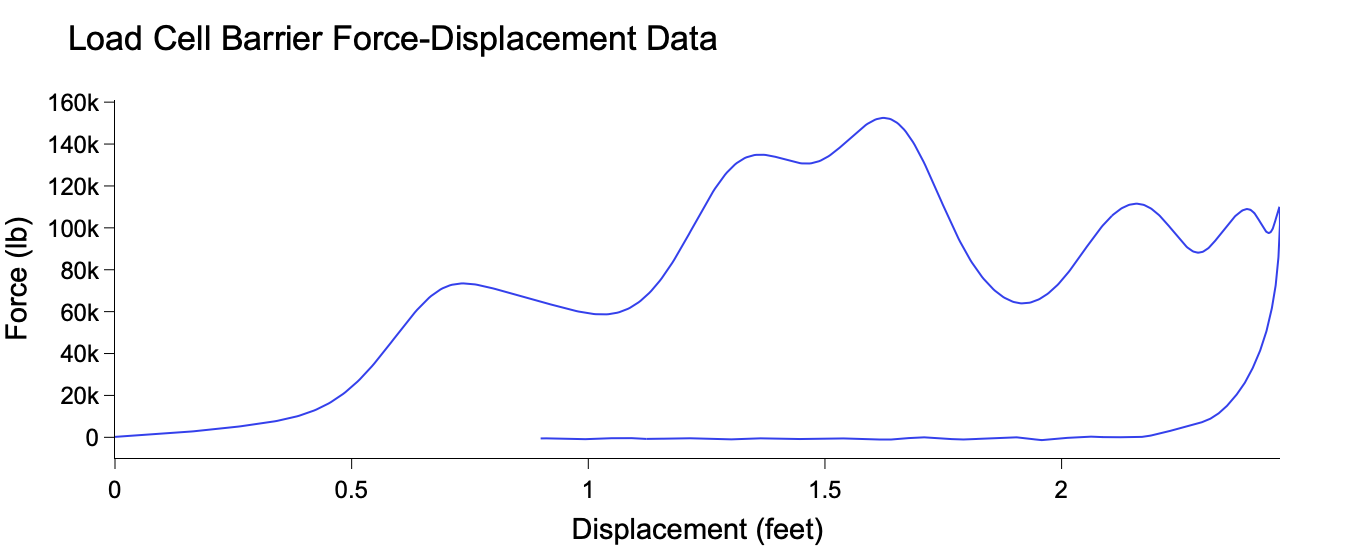

In [12]:
summed_dx['TotalForce'] = summed_dx[row_list].sum(axis=1)
arplot.plot_TotalFdx(summed_dx)

In [13]:
# import function for integrating load cell data
from pycrash.functions.ar import CrushEnergyInt
print(f'Total Crush Energy: {CrushEnergyInt(summed_dx.Disp, summed_dx.TotalForce *-1):0.0f} ft-lb')

Total Crush Energy: 179907 ft-lb


In [14]:
# import function to get barrier impact speed from weight and energy
from pycrash.functions.ar import BEVfromE
print(f'BEV from integrated load cell barrier energy: {BEVfromE(3330, CrushEnergyInt(summed_dx.Disp, summed_dx.TotalForce *-1)):0.1f} mph')

BEV from integrated load cell barrier energy: 40.2 mph


### Create Force-Displacement Response for SDOF Model
- Use load cell data for one vehicle
- Use published - force-displacement data for mutual stiffness response (Bonugli et al. 2017)

In [15]:
# example, take sum of 3 rows of load cell data  -
# sum all rows
summed_dx['Force'] = summed_dx[['F', 'G', 'H']].sum(axis=1)
veh1_fdx = summed_dx[['time', 'Disp', 'Force']].copy()  # create separate dataframe for analysis
veh1_fdx = veh1_fdx[veh1_fdx.time < 0.021].copy()  # select force up to about 1 foot of crush

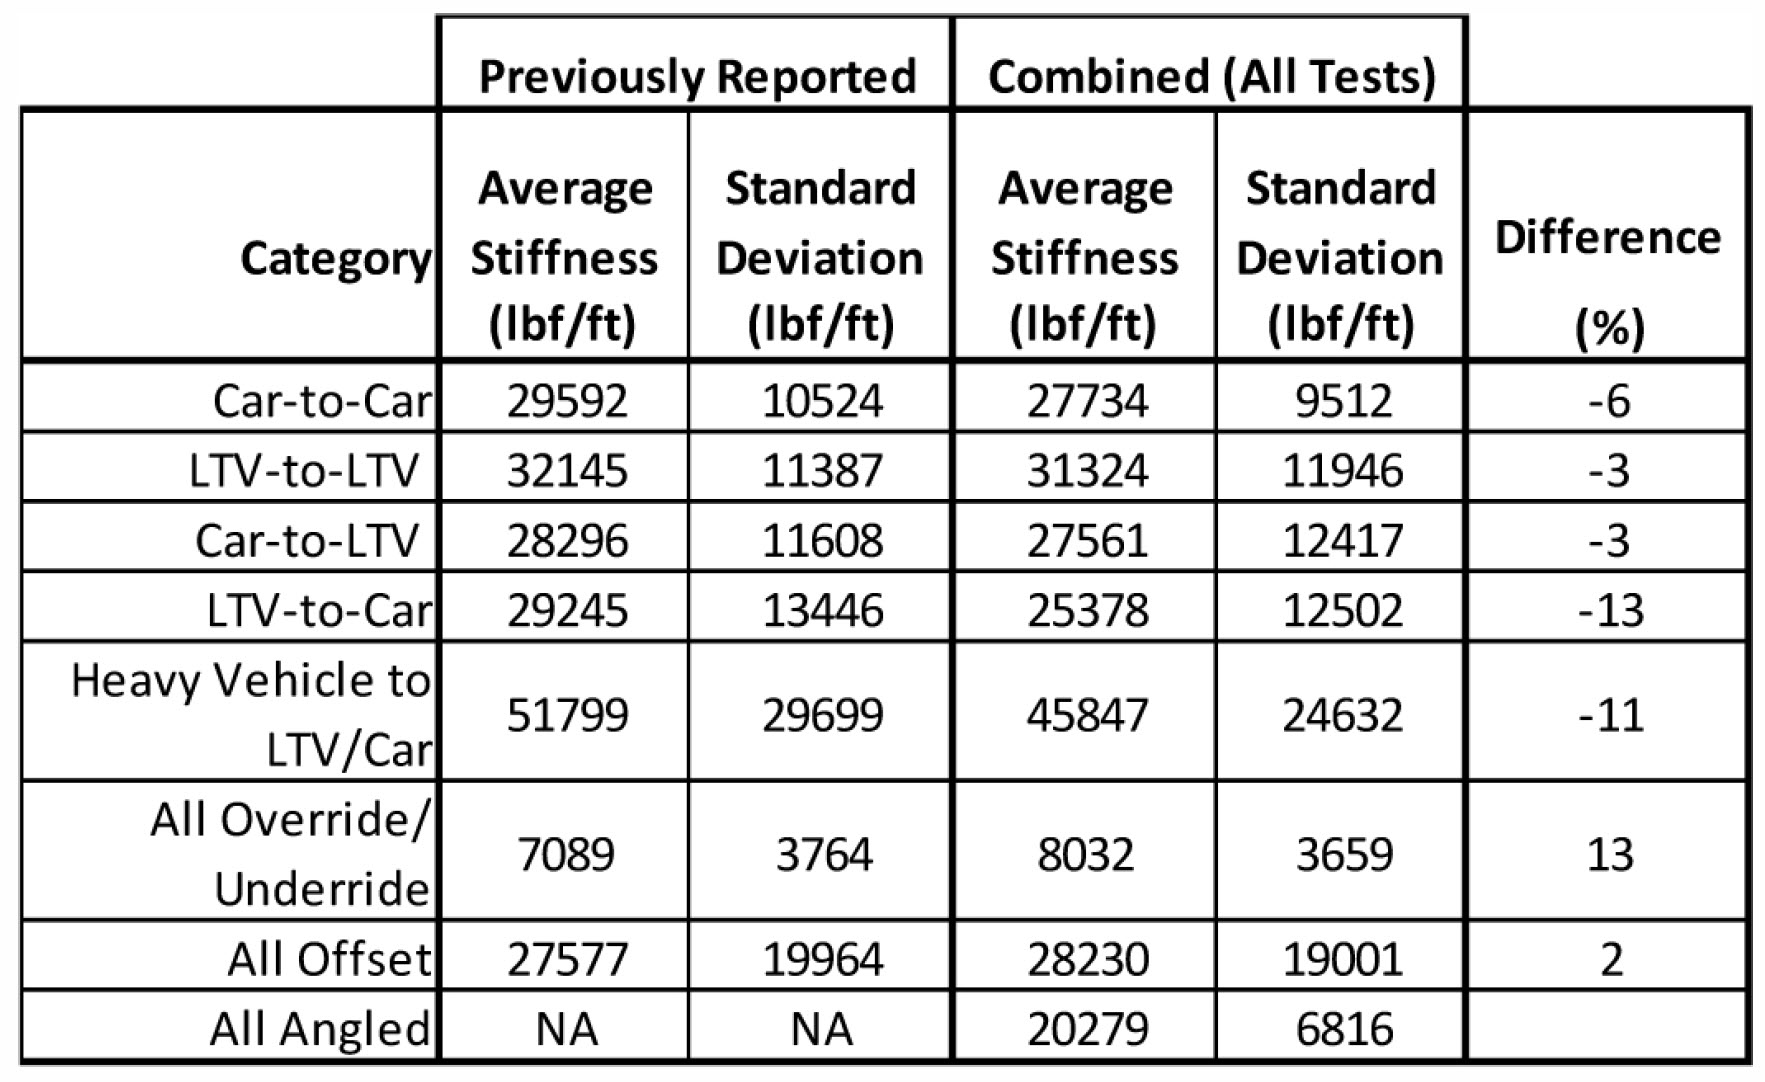

In [16]:
# use Bonugli for mutual stiffness value
from IPython.display import display, Image
display(Image(filename=os.path.join(os.getcwd(), 'visualization', 'Bonugli2017.jpg')))

In [17]:
# as an example, take Car to Car
k_mutual = 27734
k_mutual_low = k_mutual - 9512
k_mutual_high = k_mutual + 9512
# create arrays to plot
displacement = [0, 1]
f_mutual = [0, k_mutual]
f_mutual_low = [0, k_mutual_low]
f_mutual_high = [0, k_mutual_high]

In [18]:
# get initial stiffness value from load cell data
# get displacement at max force value in the first foot of crush
veh1_disp = veh1_fdx.loc[veh1_fdx.Force == veh1_fdx.Force.min(), 'Disp'].item()
print(f'Vehicle 1 Displacement at initial max force: {veh1_disp:0.3f} feet')

Vehicle 1 Displacement at initial max force: 0.727 feet


In [19]:
veh1_fdx_half = veh1_fdx[veh1_fdx.time < 0.010].copy()  # select force up to about 1/2 foot of crush
veh1_disp_half = veh1_fdx_half.loc[veh1_fdx_half.Force == veh1_fdx_half.Force.min(), 'Disp'].item()
print(f'Vehicle 1 Displacement at initial max force to half a foot: {veh1_disp_half:0.3f} feet')

Vehicle 1 Displacement at initial max force to half a foot: 0.512 feet


In [20]:
# create initial stiffness for vehicle 1:
k_veh1 = -1 * veh1_fdx.Force.min() / veh1_disp  # [lb/ft]
f_veh1 = [0, k_veh1]
print(f'Stiffness of striking vehicle: {k_veh1:0.1f} lb/ft')

Stiffness of striking vehicle: 60127.1 lb/ft


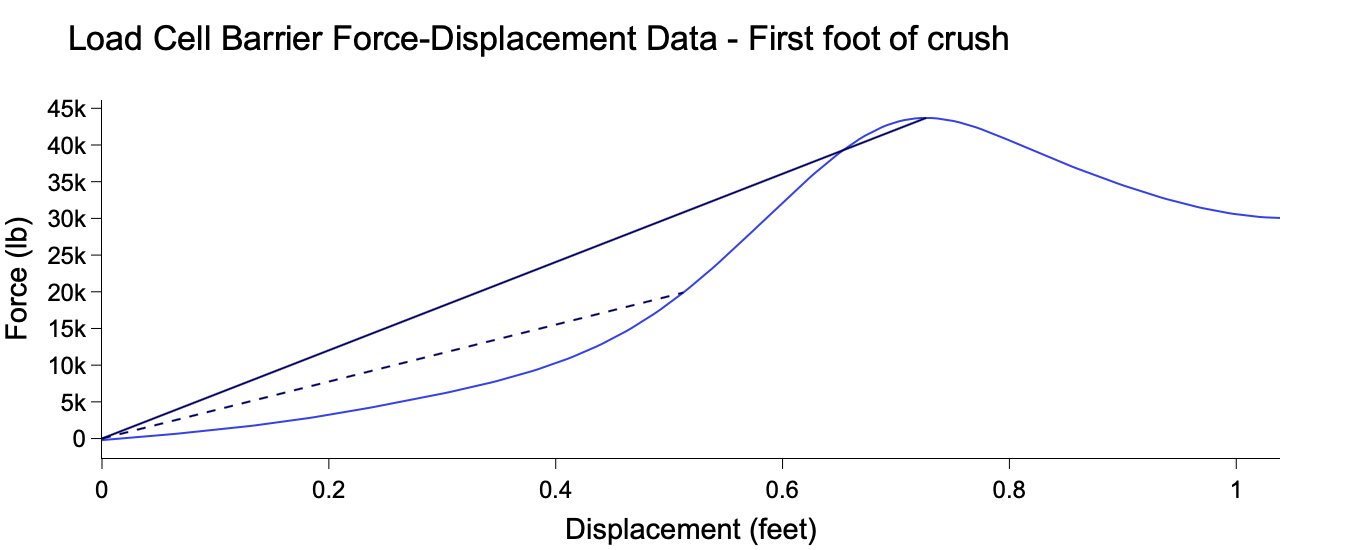

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = veh1_fdx.Disp,
                         y = veh1_fdx.Force * -1,
                        mode = 'lines',
                        name = "Total Force",
                        line = dict(color = "rgb(52, 64, 235)", width = 2)
                        ))
fig.add_trace(go.Scatter(x = [0, veh1_disp],
                         y = [0, veh1_fdx.Force.min() * -1],
                        mode = 'lines',
                        name = "Linear Stiffness (1 ft)",
                        line = dict(color = "rgb(0, 0, 100)", width = 2)
                        ))
fig.add_trace(go.Scatter(x = [0, veh1_disp_half],
                         y = [0, veh1_fdx_half.Force.min() * -1],
                        mode = 'lines',
                        name = "Linear Stiffness (1/2 ft)",
                        line = dict(color = "rgb(0, 0, 100)", width = 2, dash = 'dash')
                        ))
fig.update_layout(
    autosize = False,
    width = 1000,
    height = 550,
    title = f'Load Cell Barrier Force-Displacement Data - First foot of crush',
    template = 'plotly_white',
    xaxis = dict(showgrid = False, title = 'Displacement (feet)'),
    font = dict(family = 'Arial', size = 24, color = 'black'))

fig.update_layout(showlegend = False)
fig.update_yaxes(showgrid = False, showline=True, linewidth=1, linecolor='black', ticks="outside",
                 tickwidth=1, tickcolor='black', ticklen=10, zeroline=False, title_text = 'Force (lb)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks="outside",
                 tickwidth=1, tickcolor='black', ticklen=10, zeroline=False)
fig.show()

##### stiffness of struck vehicle is determined from mutual and striking vehicle stiffness

In [22]:
from pycrash.functions.ar import SpringSeriesKeff  # calculates mutual stiffness given stiffness value for each vehicle
# %% md
#### Example using Scipy optimize

In [23]:
from scipy.optimize import minimize

In [24]:
# create function to minimize
def objective_func(k_veh2):
    return (27734 - SpringSeriesKeff(60127.1, k_veh2))**2  # error between calculated mutual stiffness versus desired

minimize(objective_func, 30000)

      fun: 3.201567945945427e-12
 hess_inv: array([[5.93938847]])
      jac: array([1.0400588e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 9
     njev: 15
   status: 0
  success: True
        x: array([51479.01842058])

In [26]:
# try result from minimize
SpringSeriesKeff(51479, k_veh1)

27733.997477381363

In [27]:
k_veh2 = 51479  # stiffness for rear of Vehicle 2
k_veh2_low = 26145
k_veh2_high = 97875
# repeat above to get high / low values of k_veh2
def objective_func(k_veh2):
    return (k_mutual_high - SpringSeriesKeff(60127.1, k_veh2))**2 # error between calculated mutual stiffness versus desired

minimize(objective_func, 30000)

      fun: 1.7923217163900995e-18
 hess_inv: array([[23.88879238]])
      jac: array([-7.41096073e-11])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 11
     njev: 18
   status: 0
  success: True
        x: array([97875.27551559])

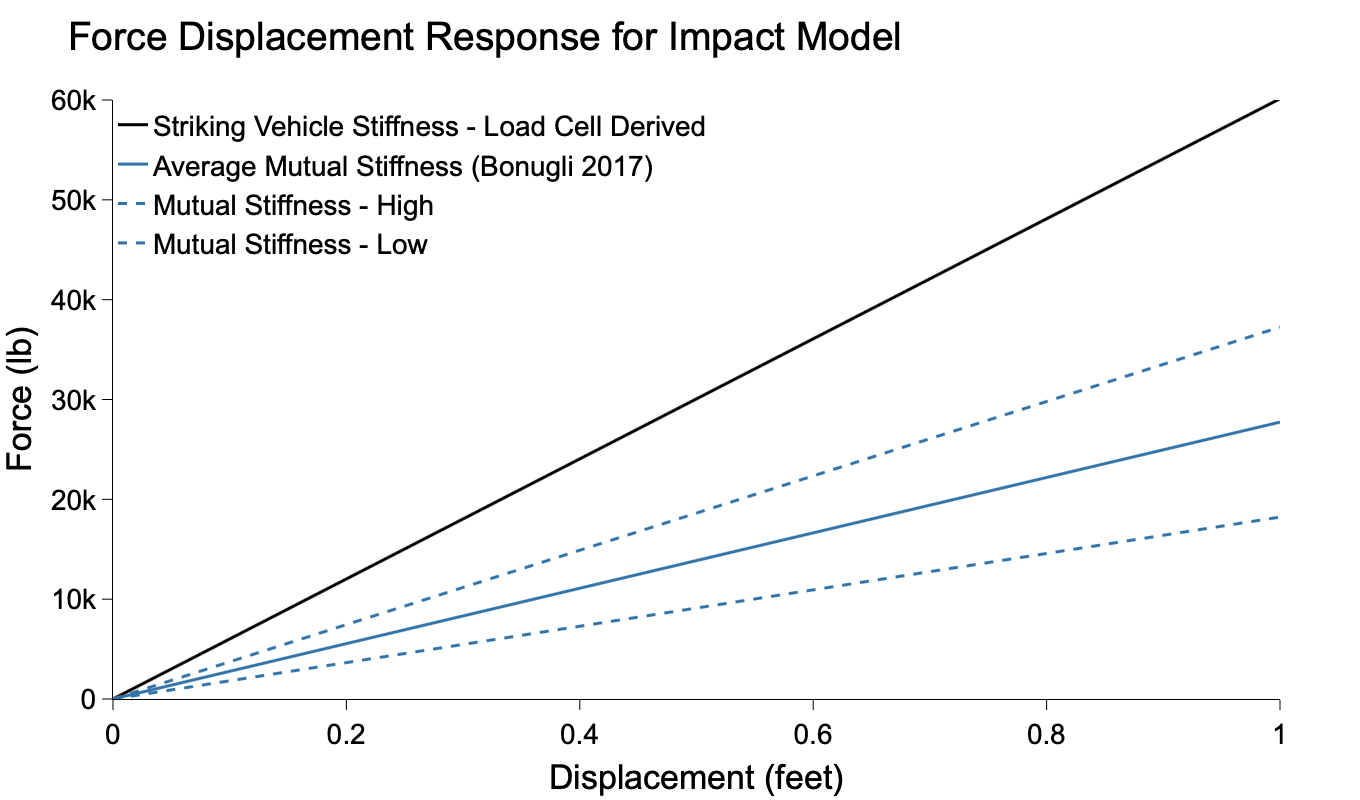

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = displacement,
                         y = f_veh1,
                        mode = 'lines',
                        name = 'Striking Vehicle Stiffness - Load Cell Derived',
                        line = dict(color = "rgb(0, 0, 0)", width = 3, dash = 'solid')
                        ))
fig.add_trace(go.Scatter(x = displacement,
                         y = f_mutual,
                        mode = 'lines',
                        name = 'Average Mutual Stiffness (Bonugli 2017)',
                        line = dict(color = "rgb(50, 115, 168)", width = 3, dash = 'solid')
                        ))
fig.add_trace(go.Scatter(x = displacement,
                         y = [0, k_mutual_high],
                        mode = 'lines',
                        name = 'Mutual Stiffness - High',
                        line = dict(color = "rgb(50, 115, 168)", width = 3, dash = 'dash')
                        ))
fig.add_trace(go.Scatter(x = displacement,
                         y = [0, k_mutual_low],
                        mode = 'lines',
                        name = 'Mutual Stiffness - Low',
                        line = dict(color = "rgb(50, 115, 168)", width = 3, dash = 'dash')
                        ))
fig.update_layout(legend = dict(orientation = "v", yanchor = 'top', y = 1, xanchor = 'left', x = 0),
    autosize = False,
    width = 1400,
    height = 800,
    title = f'Force Displacement Response for Impact Model',
    template = 'plotly_white',
    xaxis = dict(showgrid = False, title = 'Displacement (feet)'),
    font = dict(family = 'Arial', size = 28, color = 'black'))

fig.update_layout(showlegend = True)
fig.update_yaxes(showgrid = False, showline=True, linewidth=1, linecolor='black', ticks="outside",
                 tickwidth=1, tickcolor='black', ticklen=10, zeroline=False, range = [0, 60000], title_text = 'Force (lb)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks="outside",
                 tickwidth=1, tickcolor='black', ticklen=10, zeroline=False)
fig.show()